In [1]:
### Librerias Base

import numpy as np
import mapclassify
import pandas as pd
import libpysal as ps
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt


### Librerias secundarias

from h3 import h3
import contextily as ctx
from scipy.spatial import cKDTree
from shapely.geometry import Polygon


In [2]:
## Ciudad de México - Polígono
Ciudad = gpd.read_file('..\OSM\CDMX.shp')
print("Forma de los datos", Ciudad.shape)
#Ciudad.head(1)

Forma de los datos (1, 2)


In [3]:
### Construcción de geometría correspondiente al índice espacial H3 Uber.
### Se debe definir la resolución espacial del hexágono 


hexs = h3.polyfill(Ciudad.geometry[0].__geo_interface__, 9, geo_json_conformant = True) ## Valor de resolución 9

polygonise = lambda hex_id: Polygon(
                                  h3.h3_to_geo_boundary(
                                      hex_id, geo_json=True)
                                    )

all_polys = gpd.GeoSeries(list(map(polygonise, hexs)), \
                                      index=hexs, \
                                      crs="EPSG:4326" \
                                      ) ### Sistema de proyección shp

In [4]:
### Se procede a convertir la serie de datos geográficos a GeoDataFrame
Cdmx = gpd.GeoDataFrame(gpd.GeoSeries(all_polys))
### Se designa la geometria para el GeoDataFrame
Cdmx = Cdmx.rename(columns={0:'geometry'}).set_geometry('geometry')
## Se le asigna nombre al indice
Cdmx.index.name = 'hex'
## Reset de index
Cdmx_hex = Cdmx.reset_index()
print("Forma de los datos", Cdmx_hex.shape)
Cdmx_hex2 = Cdmx_hex.copy()
print ("Forma de Hexagonos CdMx: ", Cdmx_hex2.shape)

#Cdmx_hex.head(2)

Forma de los datos (12329, 2)
Forma de Hexagonos CdMx:  (12329, 2)


In [5]:
##### LLAMADAS 911

df_01 = pd.read_csv ('..\TABLAS_911\911_2020_segundo_semestre.csv')
print('Forma de los datos: ', df_01.shape)
df_01.head(4)

Forma de los datos:  (533705, 18)


,folio,incidente_c4,fecha_creacion,hora_creacion,mes_creacion,año_creacion,fecha_cierre,mes_cierre,año_cierre,hora_cierre,colonia,codigo_cierre,clas_con_f_alarma,delegacion_cierre,manzana,longitud_centroide,latitud_centroide,geometry
0,C5/200702/07369,Lesionado-Caída,2020-07-02,21:25:59,Julio,2020,2020-07-02,Julio,2020,21:30:35,SALVADOR DIAZ MIRON,Duplicado,URGENCIAS MEDICAS,GUSTAVO A. MADERO,0900500012907021,-99.09506,19.48655,"MULTIPOLYGON (((-99.09512274 19.4871496299991,..."
1,C5/200702/07404,Lesionado-Caída,2020-07-02,21:30:30,Julio,2020,2020-07-02,Julio,2020,22:29:43,DEL VALLE,Afirmativo,URGENCIAS MEDICAS,BENITO JUAREZ,0901400010257024,-99.16083,19.39354,"MULTIPOLYGON (((-99.16050212 19.3939641699992,..."
2,C5/200702/07419,Denuncia-Hechos,2020-07-02,21:32:27,Julio,2020,2020-07-02,Julio,2020,21:42:31,OBRERA,Negativo,SERVICIO,CUAUHTEMOC,0901500011144017,-99.14011,19.41770,"MULTIPOLYGON (((-99.14056138 19.4175488299992,..."
3,C5/200702/07300,Agresión-Casa Habitación,2020-07-02,21:13:59,Julio,2020,2020-07-02,Julio,2020,22:05:50,SAN JOSE,Duplicado,DELITO,MILPA ALTA,0900900360223055,-99.00204,19.17844,NaN


In [6]:
## Lista de fechas
#df_01.fecha_cierre.unique()

In [7]:
df_01.groupby(['clas_con_f_alarma']).size()

clas_con_f_alarma
DELITO               109205
EMERGENCIA            35944
FALSA ALARMA           6010
FALTA CÍVICA         178597
SERVICIO             136708
URGENCIAS MEDICAS     67241
dtype: int64

In [8]:
df_01.shape

(533705, 18)

In [9]:
Delitos = df_01[df_01['clas_con_f_alarma'].isin(['DELITO'])]
print ("Forma de los datos: ", Delitos.shape)

Forma de los datos:  (109205, 18)


In [10]:
Casa_Habita = Delitos[Delitos["incidente_c4"].isin(['Agresión-Casa Habitación','Daños-Casa habitación'])]
print ("Forma de los datos: ", Casa_Habita.shape)

Forma de los datos:  (11713, 18)


In [11]:
Casa_Habita.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11713 entries, 3 to 533562
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   folio               11713 non-null  object 
 1   incidente_c4        11713 non-null  object 
 2   fecha_creacion      11713 non-null  object 
 3   hora_creacion       11713 non-null  object 
 4   mes_creacion        11713 non-null  object 
 5   año_creacion        11713 non-null  int64  
 6   fecha_cierre        11713 non-null  object 
 7   mes_cierre          11713 non-null  object 
 8   año_cierre          11713 non-null  int64  
 9   hora_cierre         11713 non-null  object 
 10  colonia             11709 non-null  object 
 11  codigo_cierre       11713 non-null  object 
 12  clas_con_f_alarma   11713 non-null  object 
 13  delegacion_cierre   11713 non-null  object 
 14  manzana             11602 non-null  object 
 15  longitud_centroide  11713 non-null  float64
 16  lat

In [12]:
#Casa_Habita.groupby(['longitud_centroide']).size()

In [13]:
Casa_Habita_Geo = gpd.GeoDataFrame(
    Casa_Habita, geometry=gpd.points_from_xy(Casa_Habita.longitud_centroide, Casa_Habita.latitud_centroide))
Casa_Habita_Geo = gpd.GeoDataFrame(Casa_Habita_Geo, geometry=Casa_Habita_Geo['geometry'])
Casa_Habita_Geo.crs = "EPSG:4326"
Casa_Habita_Geo = Casa_Habita_Geo.to_crs("EPSG:4326")
Casa_Habita_Geo.shape

(11713, 18)

In [14]:
### Forma de los datos...

print ("Forma de Hexagonos CdMx: ", Cdmx_hex2.shape)
print ("Forma Delitos Casa Habitación - Inmueble- CdMx: ", Casa_Habita_Geo.shape)

Forma de Hexagonos CdMx:  (12329, 2)
Forma Delitos Casa Habitación - Inmueble- CdMx:  (11713, 18)


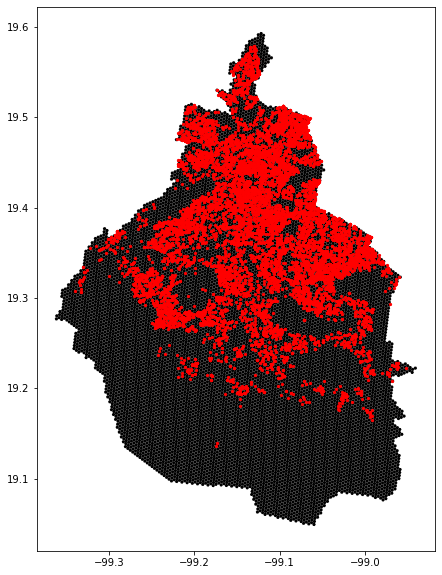

In [15]:
### Hospitales públicos y privados en CdMx
base = Cdmx_hex2.plot(color='black',figsize=(10,10))
Casa_Habita_Geo.plot(ax=base, color='red', markersize = 5, figsize=(10,10))

In [16]:
### Spatial Join... Asignacion Delito a Hex con FOLIO... 
### Se sabe que solo un folio a un delito


DEL_HEX = gpd.sjoin(Cdmx_hex2, Casa_Habita_Geo[['folio', 'geometry']], how="right", op='contains')
print ("Forma de Spatial Join: ", DEL_HEX["folio"].value_counts().shape)
#merge.head(2)

Forma de Spatial Join:  (11713,)


In [17]:
C_DEL_HEX = DEL_HEX[['hex', 'folio']]
C_DEL_HEX = (C_DEL_HEX.groupby('hex').count()).rename(columns={"folio": "Value"}).replace(np.nan, 0)
C_DEL_HEX.shape

(3572, 1)

In [18]:
### 86364
C_DEL_HEX.head(2)

,Value
hex,
8949864921bffff,1
89498649233ffff,1


In [19]:
Hex_FN = C_DEL_HEX.join(Cdmx_hex2.set_index('hex'), how='right')
Hex_FN = gpd.GeoDataFrame(Hex_FN, geometry=Hex_FN['geometry'])
Hex_FN.crs = "EPSG:4326"
Hex_FN = Hex_FN.to_crs("EPSG:4326")
Hex_FN = Hex_FN.replace(np.nan, 0)
print ("Forma de Hexagonos CdMx: ", Hex_FN.shape)

Forma de Hexagonos CdMx:  (12329, 2)


In [20]:
%time mapclassify.NaturalBreaks(Hex_FN['Value'].values, k=6)

Wall time: 140 ms


NaturalBreaks         

   Interval      Count
----------------------
[ 0.00,  0.00] |  8757
( 0.00,  1.00] |  1115
( 1.00,  3.00] |  1245
( 3.00,  6.00] |   800
( 6.00, 10.00] |   321
(10.00, 19.00] |    91

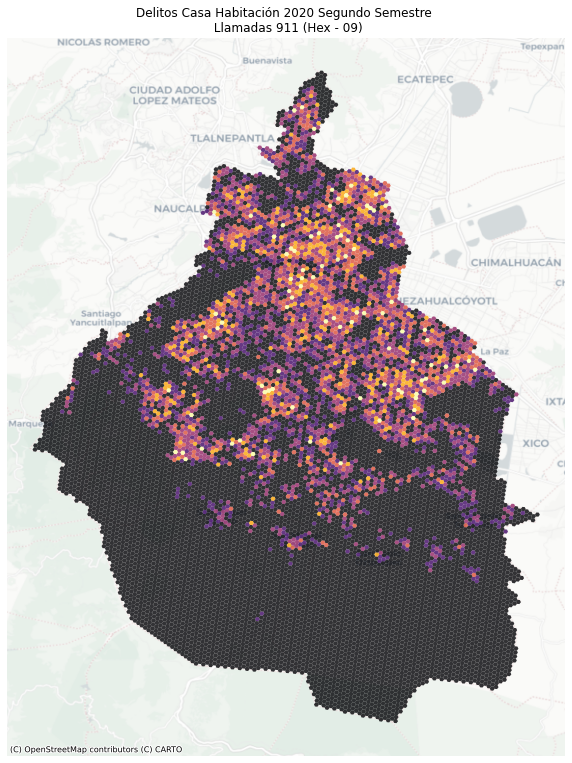

In [21]:
### Se mapea sobre los hexa que contienen a las viviendas la accesibilidad
## Se recuerda que los hex son count de vivindas; una misma clave para varias casas.

fig, ax = plt.subplots(figsize=(10, 15))
ax = Hex_FN.plot(ax=ax, column='Value',
                                            legend=False,
                                            alpha=0.8,
                                            scheme='NaturalBreaks',
                                            cmap='inferno',
                                            classification_kwds={'k':6})
ax.set(title='Delitos Casa Habitación 2020 Segundo Semestre \n Llamadas 911 (Hex - 09)')
ax.set_axis_off()
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs=Hex_FN.crs.to_string())
plt.savefig("..\TABLAS_911\Casa Habitación 2020 Segundo Semestre")

In [25]:
Hex_EX = Hex_FN.copy()
Hex_EX = Hex_EX.reset_index()
Hex_EX_2 = Hex_EX[['hex', 'Value']]
Hex_EX_2 = Hex_EX_2.rename({'Value': 'D_CasHa'}, axis=1)
Hex_EX_2.head(2)

,hex,D_CasHa
0,894995853cfffff,0.0
1,894995aa46fffff,1.0


In [23]:
#Hex_EX.to_csv("..\TABLAS_911\Casa_2020_SegundoSemestre.csv")